In [1]:
!pip install pyod

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 147.7/147.7 KB 3.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyod: filename=pyod-1.0.7-py3-none-any.whl size=181101 sha256=afada96b44e361f2bc610eca92945e8c2d86ec0bcb874ca3b4345f2aabf18e8f
  Stored in directory: /root/.cache/pip/wheels/f7/e2/c1/1c7fd8b261e72411f6509afb429c84532e40ddcd96074473f4
Successfully built pyod


In [2]:
# !pip install mglearn
# #memory = Memory(location = None)

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings(action='ignore')

from sklearn.preprocessing import RobustScaler, MinMaxScaler, StandardScaler
from pyod.models.iforest import IForest
from pyod.models.pca import PCA
from sklearn.neighbors import LocalOutlierFactor
from pyod.models.mcd import MCD
from sklearn.svm import OneClassSVM
from sklearn.linear_model import LinearRegression

In [4]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [5]:
data=pd.read_csv('/content/drive/MyDrive/bistelligence/BIS_data/BISTelligen_Project_Data.csv')

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1764 entries, 0 to 1763
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   key              1764 non-null   int64  
 1   Pressure         1764 non-null   float64
 2   Power1           1764 non-null   float64
 3   Power2           1764 non-null   float64
 4   Vibration_Peak1  1764 non-null   float64
 5   Vibration_RMS1   1764 non-null   float64
 6   Vibration_Peak2  1764 non-null   float64
 7   Vibration_RMS2   1764 non-null   float64
dtypes: float64(7), int64(1)
memory usage: 110.4 KB


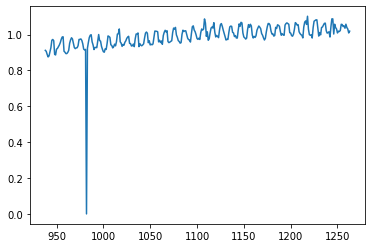

In [7]:
plt.plot(data[data['key']==4]['Vibration_RMS2'])

In [8]:
# linear regression 이용한 noise data imputation
noise_index = data.loc[data['Vibration_RMS2']<0,'Vibration_RMS2'].index
data1 = data.drop(noise_index, axis=0).copy()
data.loc[data['Vibration_RMS2']<0,'Vibration_RMS2']= LinearRegression().fit(pd.DataFrame(data1['Vibration_Peak2']),pd.DataFrame(data1['Vibration_RMS2'])).predict(pd.DataFrame(data.loc[data['Vibration_RMS2']<0, 'Vibration_Peak2']))[0][0]

In [9]:
# # noise data 발생 지점 기준으로 이전 40개 인덱스, 이후 40개 인덱스에 대한 Vibration_RMS2 평균값으로 대체
# # noise data index=982, index 942~981(40개), index 983~1022(40개)
# prev_sum=data[data['key']==4].loc[942:981]['Vibration_RMS2'].sum()
# after_sum=data[data['key']==4].loc[983:1022]['Vibration_RMS2'].sum()
# aver=(prev_sum+after_sum)/80
# data.loc[data['Vibration_RMS2']<0,'Vibration_RMS2']=aver

In [10]:
sum1 = 0
total = 0
for i in range(len(data)):
    total += 1
    sum1 += 1
    if (i == len(data) - 1) :
        print(str(int(data.iloc[i]['key'])) + '값의 개수 : ' + str(sum1))
        print('전체 데이터셋 행개수 : ' + str(total))
        break
    else :
        if (data.iloc[i]['key'] == data.iloc[i + 1]['key']) :
              continue
        else :
            print(str(int(data.iloc[i]['key'])) + '값의 개수 : ' + str(sum1))
            sum1 = 0

1값의 개수 : 330
2값의 개수 : 300
3값의 개수 : 308
4값의 개수 : 326
5값의 개수 : 250
6값의 개수 : 250
전체 데이터셋 행개수 : 1764


In [11]:
def normal_select(data, num, start_key=1, end_key=6):
    correct_dataframe = pd.DataFrame()
    for key in range(start_key,end_key+1):
        new_df = data[data['key']==key][:num]
        correct_dataframe = pd.concat([correct_dataframe,new_df])
    #정상치만 모은 데이터프레임
    normal_index=correct_dataframe.index
    correct_dataframe.reset_index(drop=True, inplace=True)
    correct_dataframe.head()
    return correct_dataframe,normal_index

In [12]:
#전체 key에 대한 정상 범주 지정
normal_df,normal_index=normal_select(data, 50)
normal_key = normal_df['key']
normal_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300 entries, 0 to 299
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   key              300 non-null    int64  
 1   Pressure         300 non-null    float64
 2   Power1           300 non-null    float64
 3   Power2           300 non-null    float64
 4   Vibration_Peak1  300 non-null    float64
 5   Vibration_RMS1   300 non-null    float64
 6   Vibration_Peak2  300 non-null    float64
 7   Vibration_RMS2   300 non-null    float64
dtypes: float64(7), int64(1)
memory usage: 18.9 KB


In [13]:
scaler= RobustScaler()
train_key = normal_df['key']
train_data=pd.DataFrame(scaler.fit_transform(normal_df.drop(['key'],axis=1)),columns=normal_df.columns[1:])
# scaling 후
train_data.describe()

,Pressure,Power1,Power2,Vibration_Peak1,Vibration_RMS1,Vibration_Peak2,Vibration_RMS2
count,3.000000e+02,300.000000,300.000000,300.000000,3.000000e+02,300.000000,3.000000e+02
mean,-1.445328e-02,0.003937,0.210534,0.123429,-1.689704e-01,0.016966,2.039328e-02
std,9.220173e-01,0.737883,0.527092,0.791561,6.447691e-01,0.599990,5.927490e-01
min,-3.059428e+00,-1.964014,-0.797288,-1.819935,-2.029524e+00,-1.242777,-1.201110e+00
25%,-4.918457e-01,-0.512773,-0.213552,-0.394883,-6.547003e-01,-0.494840,-4.740072e-01
50%,-1.054235e-14,0.000000,0.000000,0.000000,2.455447e-15,0.000000,-7.709220e-16
75%,5.081543e-01,0.487227,0.786448,0.605117,3.452997e-01,0.505160,5.259928e-01
max,2.399432e+00,1.745613,1.307227,2.486562,9.560564e-01,1.329804,1.757214e+00


In [14]:
# test data (전체 데이터셋)
test_key = data['key']
test_data=data.drop(['key'],axis=1)
test_data=pd.DataFrame(scaler.transform(test_data),columns=test_data.columns)
test_data.describe()

,Pressure,Power1,Power2,Vibration_Peak1,Vibration_RMS1,Vibration_Peak2,Vibration_RMS2
count,1764.000000,1764.000000,1764.000000,1764.000000,1764.000000,1764.000000,1764.000000
mean,1.760424,0.657090,0.314088,0.409945,0.228072,0.453872,0.916546
std,5.722925,1.975311,0.752346,0.800987,0.957831,0.661025,0.807698
min,-3.059428,-2.149009,-0.808092,-1.819935,-2.029524,-1.242777,-1.201110
25%,-0.327871,-0.316639,-0.222741,-0.161965,-0.237233,0.021549,0.411042
50%,0.239985,0.276314,0.002717,0.359183,0.197483,0.418189,0.862746
75%,1.214029,0.943862,0.833370,0.942812,0.494455,0.794674,1.463967
max,44.786253,15.807580,4.980267,2.957844,8.139999,4.305030,5.827024


In [15]:
init_train_data = normal_df.drop(['key'],axis=1)
init_test_data = data.drop(['key'],axis=1)
init_test_data.describe()

,Pressure,Power1,Power2,Vibration_Peak1,Vibration_RMS1,Vibration_Peak2,Vibration_RMS2
count,1764.000000,1764.000000,1764.000000,1764.000000,1764.000000,1764.000000,1764.000000
mean,1029.587995,1796.089208,2164.182666,473.236279,1.859088,1769.655457,0.998792
std,30.857242,56.299360,174.158013,14.674220,0.043308,88.254406,0.058160
min,1003.600000,1716.111111,1904.412839,432.384464,1.757011,1543.133416,0.846306
25%,1018.328190,1768.336433,2039.913975,462.758782,1.838049,1711.935295,0.962392
50%,1021.389993,1785.236494,2092.104392,472.306302,1.857705,1764.891307,0.994918
75%,1026.641906,1804.262637,2284.389567,482.998497,1.871132,1815.156379,1.038209
max,1261.577503,2227.901131,3244.341245,519.914237,2.216824,2283.829118,1.352378


# modeling

### LOF

In [16]:
plt.rcParams['figure.figsize'] = (12, 8)

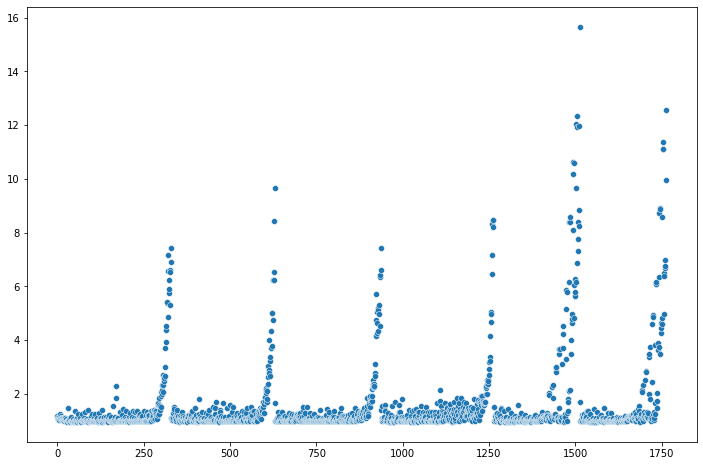

In [17]:
# init
model_lof = LocalOutlierFactor(contamination=0.01,novelty=True)

model_lof.fit(init_train_data)
sns.scatterplot(init_test_data.index,-model_lof.score_samples(init_test_data));

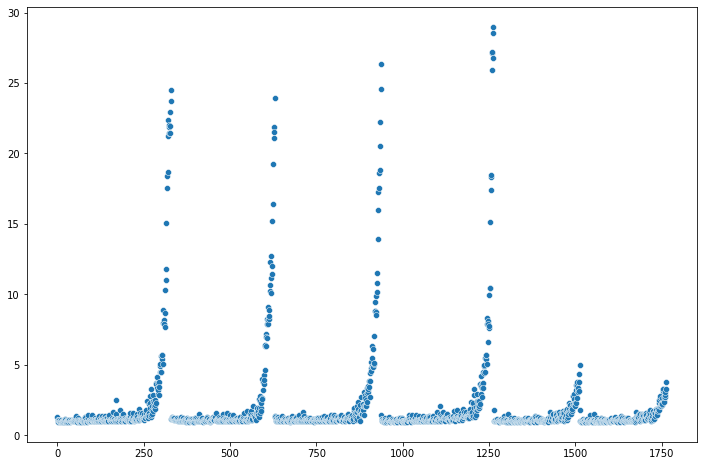

In [18]:
#scaling
model_lof = LocalOutlierFactor(contamination=0.01,novelty=True)

model_lof.fit(train_data)
sns.scatterplot(test_data.index,-model_lof.score_samples(test_data));

# gmm

converged: True
covariance :  tied
n_components :  13


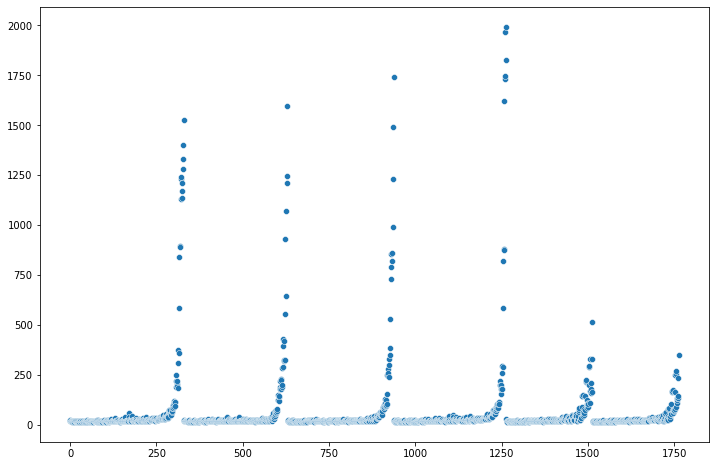

In [19]:
from sklearn.mixture import GaussianMixture

lowest_bic = np.infty
bic = []
n_components_range = range(1, 15)
cv_types = ["spherical", "tied", "diag", "full"]
for cv_type in cv_types:
    for n_components in n_components_range:
        gmm = GaussianMixture(
            n_components=n_components, covariance_type=cv_type,
            random_state = 2, max_iter = 100
        )
        gmm.fit(init_train_data)
        bic.append(gmm.bic(init_train_data))
        if bic[-1] < lowest_bic:
            lowest_bic = bic[-1]
            best_gmm = gmm

print('converged:', best_gmm.converged_)
print("covariance : ", best_gmm.covariance_type)
print("n_components : ", best_gmm.n_components)

score = best_gmm.score_samples(init_test_data)
sns.scatterplot(init_test_data.index,-score);

converged: True
covariance :  tied
n_components :  8


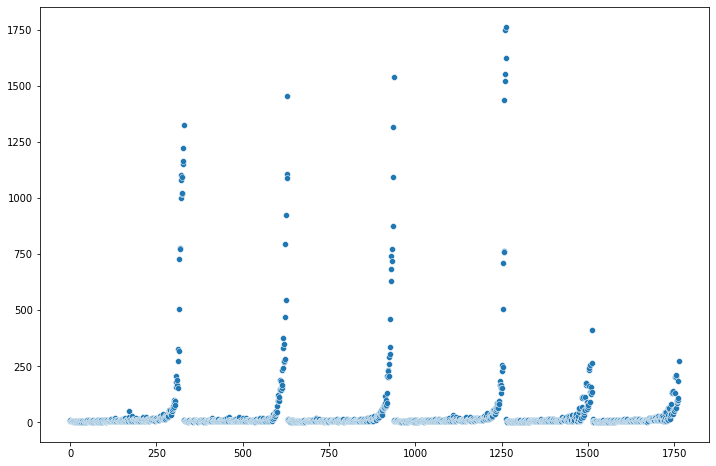

In [20]:
from sklearn.mixture import GaussianMixture

lowest_bic = np.infty
bic = []
n_components_range = range(1, 15)
cv_types = ["spherical", "tied", "diag", "full"]
for cv_type in cv_types:
    for n_components in n_components_range:
        gmm = GaussianMixture(
            n_components=n_components, covariance_type=cv_type,
            random_state = 2, max_iter = 100
        )
        gmm.fit(train_data)
        bic.append(gmm.bic(train_data))
        if bic[-1] < lowest_bic:
            lowest_bic = bic[-1]
            best_gmm = gmm

print('converged:', best_gmm.converged_)
print("covariance : ", best_gmm.covariance_type)
print("n_components : ", best_gmm.n_components)

score = best_gmm.score_samples(test_data)
sns.scatterplot(test_data.index,-score);

# MCD

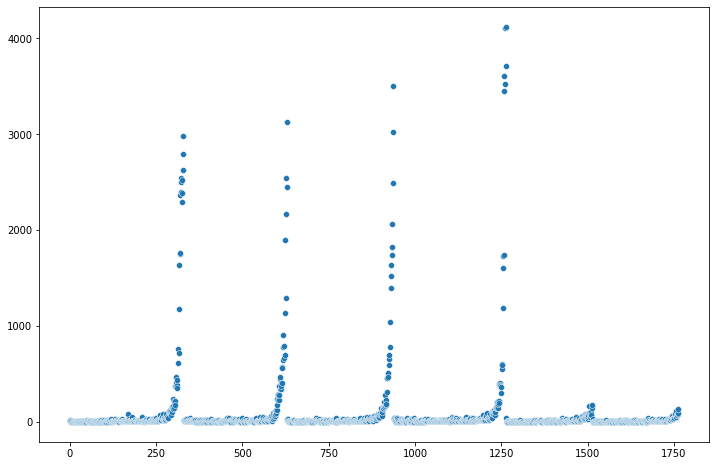

In [21]:
model_mcd = MCD(contamination=0.01,random_state=42)
model_mcd.fit(init_train_data)
sns.scatterplot(init_test_data.index,model_mcd.decision_function(init_test_data));

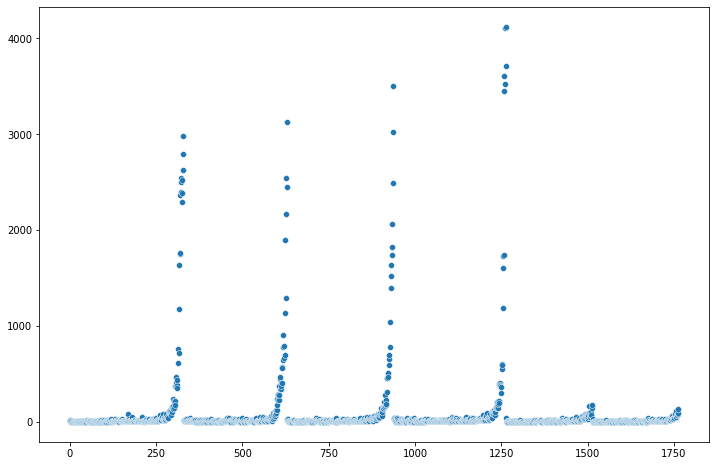

In [22]:
model_mcd = MCD(contamination=0.01,random_state=42)
model_mcd.fit(train_data)
sns.scatterplot(test_data.index,model_mcd.decision_function(test_data));

# AutoEncoder

In [38]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers,losses,models
from tensorflow.keras.models import Model, load_model
from keras.callbacks import EarlyStopping, ModelCheckpoint
import random
import os

def my_seed_everywhere(seed: int = 2):
    random.seed(seed) # random
    np.random.seed(seed) # np
    os.environ["PYTHONHASHSEED"] = str(seed) # os
    tf.random.set_seed(seed) # tensorflow

my_seed = 2
my_seed_everywhere(my_seed)

In [ ]:
input_dim=train_data.shape[1]
#tf.random.set_seed(2)
initializer = tf.keras.initializers.HeNormal(seed=2)
momentum = 0.9
early_stopping = EarlyStopping(monitor='val_loss', mode='min', verbose=1,patience=10)
check_point = ModelCheckpoint('best_ae_model.h5',monitor='val_loss',mode='min',save_best_only=True)


encoder=models.Sequential([
    #input layer
    layers.InputLayer(input_shape=input_dim),

    layers.Dense(64,kernel_initializer=initializer),
    layers.BatchNormalization(momentum=momentum),
    layers.ReLU(),
    
    layers.Dense(32,kernel_initializer=initializer),
    layers.BatchNormalization(momentum=momentum),
    layers.ReLU(),
    
    layers.Dense(16,kernel_initializer=initializer),
    layers.BatchNormalization(momentum=momentum),
    layers.ReLU(),
    
    layers.Dense(8,kernel_initializer=initializer),
    layers.BatchNormalization(momentum=momentum),
    layers.ReLU(),
    
    layers.Dense(4,kernel_initializer=initializer),
    layers.BatchNormalization(momentum=momentum),
    layers.ReLU(),
])

decoder=models.Sequential([ 
    
    layers.Dense(4,kernel_initializer=initializer),
    layers.BatchNormalization(momentum=momentum),
    layers.ReLU(),
    
    layers.Dense(8,kernel_initializer=initializer),
    layers.BatchNormalization(momentum=momentum),
    layers.ReLU(),
    
    layers.Dense(16,kernel_initializer=initializer),
    layers.BatchNormalization(momentum=momentum),
    layers.ReLU(),
    
    layers.Dense(32,kernel_initializer=initializer),
    layers.BatchNormalization(momentum=momentum),
    layers.ReLU(),
    
    layers.Dense(64,kernel_initializer=initializer),
    layers.BatchNormalization(momentum=momentum),
    layers.ReLU(),
    
    #output layer
    layers.Dense(input_dim,kernel_initializer=initializer),
])

model_ae=models.Sequential([
    encoder,decoder
])

model_ae.compile(optimizer=keras.optimizers.Adam(learning_rate = 0.03), 
                    loss=keras.losses.MeanSquaredError())

history = model_ae.fit(
    train_data,train_data,
    shuffle=True,
    epochs=100,
    batch_size=32,
    validation_split = 0.3,
    callbacks = [early_stopping, check_point]
)

56/56 [==============================] - 0s 2ms/step


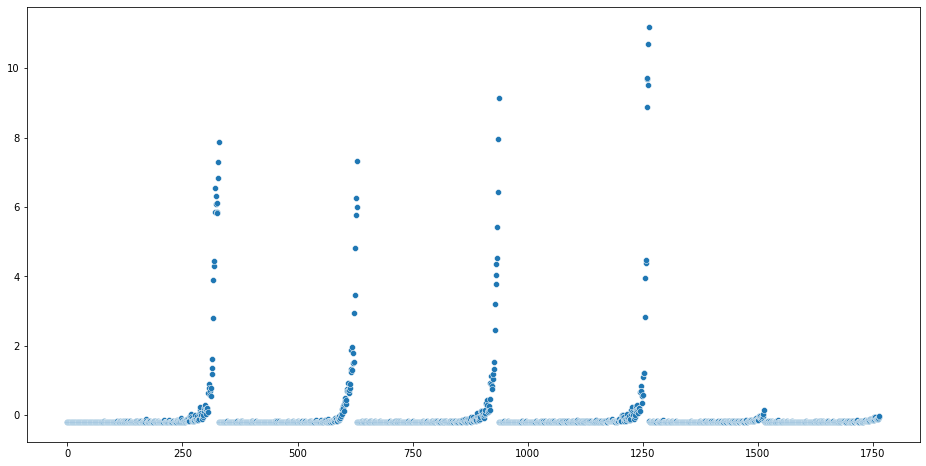

In [25]:
# z-score
model_ae = load_model('best_ae_model.h5')
reconstruction = model_ae.predict(test_data)

mse = np.mean(np.power(test_data-reconstruction,2),axis=1)

import scipy.stats as ss
z_score = ss.zscore(mse)

plt.rcParams['figure.figsize']=(16,8)
sns.scatterplot(test_data.index,z_score);


In [44]:
def my_seed_everywhere(seed: int = 2):
    random.seed(seed) # random
    np.random.seed(seed) # np
    os.environ["PYTHONHASHSEED"] = str(seed) # os
    tf.random.set_seed(seed) # tensorflow

my_seed = 2
my_seed_everywhere(my_seed)

In [ ]:
# init data
input_dim=init_train_data.shape[1]
tf.random.set_seed(2)
#initializer = tf.keras.initializers.HeNormal(seed=2)
initializer = tf.keras.initializers.GlorotUniform(seed=2)
momentum = 0.9
early_stopping = EarlyStopping(monitor='val_loss', mode='min', verbose=1,patience=10)
check_point = ModelCheckpoint('best_ae_model.h5',monitor='val_loss',mode='min',save_best_only=True)


encoder=models.Sequential([
    #input layer
    layers.InputLayer(input_shape=input_dim),

    layers.Dense(64,kernel_initializer=initializer),
    #layers.BatchNormalization(momentum=momentum),
    layers.ReLU(),
    
    layers.Dense(32,kernel_initializer=initializer),
    #layers.BatchNormalization(momentum=momentum),
    layers.ReLU(),
    
    layers.Dense(16,kernel_initializer=initializer),
    #layers.BatchNormalization(momentum=momentum),
    layers.ReLU(),
    
    layers.Dense(8,kernel_initializer=initializer),
    #layers.BatchNormalization(momentum=momentum),
    layers.ReLU(),
    
    layers.Dense(4,kernel_initializer=initializer),
    #layers.BatchNormalization(momentum=momentum),
    layers.ReLU(),
])

decoder=models.Sequential([ 
    
    layers.Dense(4,kernel_initializer=initializer),
    #layers.BatchNormalization(momentum=momentum),
    layers.ReLU(),
    
    layers.Dense(8,kernel_initializer=initializer),
    #layers.BatchNormalization(momentum=momentum),
    layers.ReLU(),
    
    layers.Dense(16,kernel_initializer=initializer),
    #layers.BatchNormalization(momentum=momentum),
    layers.ReLU(),
    
    layers.Dense(32,kernel_initializer=initializer),
    #layers.BatchNormalization(momentum=momentum),
    layers.ReLU(),
    
    layers.Dense(64,kernel_initializer=initializer),
    #layers.BatchNormalization(momentum=momentum),
    layers.ReLU(),
    
    #output layer
    layers.Dense(input_dim,kernel_initializer=initializer),
])

model_ae=models.Sequential([
    encoder,decoder
])

model_ae.compile(optimizer=keras.optimizers.Adam(learning_rate = 0.03), 
                    loss=keras.losses.MeanSquaredError())

history = model_ae.fit(
    init_train_data,init_train_data,
    shuffle=True,
    epochs=100,
    batch_size=32,
    validation_split = 0.3,
    callbacks = [early_stopping, check_point]
)

56/56 [==============================] - 0s 1ms/step


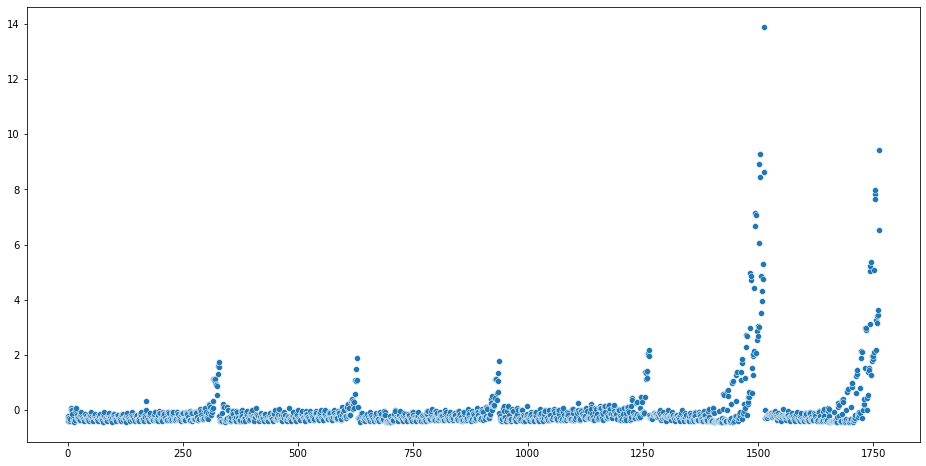

In [27]:
# z-score
model_ae = load_model('best_ae_model.h5')
reconstruction = model_ae.predict(init_test_data)

mse = np.mean(np.power(init_test_data-reconstruction,2),axis=1)

import scipy.stats as ss
z_score = ss.zscore(mse)

plt.rcParams['figure.figsize']=(16,8)
sns.scatterplot(init_test_data.index,z_score)

# OCSVM

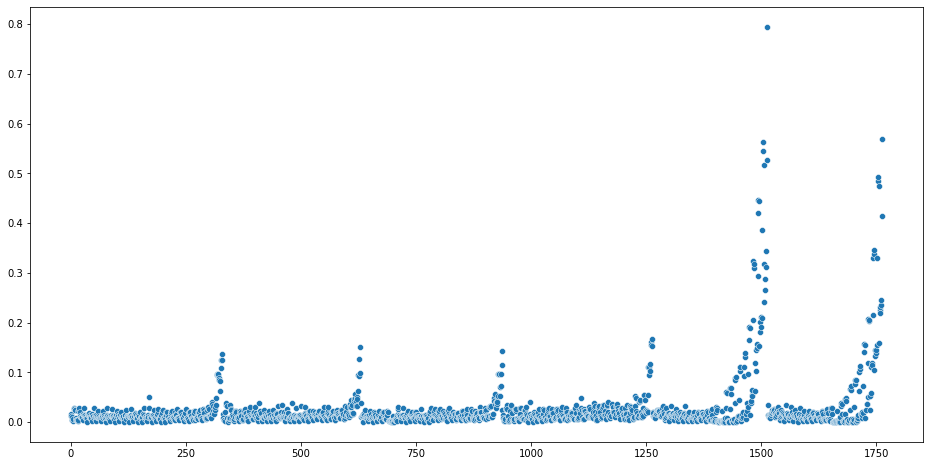

In [28]:
# Init
model_ocsvm = OneClassSVM(nu=0.01)

model_ocsvm.fit(init_train_data)
#positive : inlier , negative : outlier
ocsvm_anomaly_score = np.max(model_ocsvm.decision_function(init_test_data))-(model_ocsvm.decision_function(init_test_data))
sns.scatterplot(init_test_data.index,ocsvm_anomaly_score)

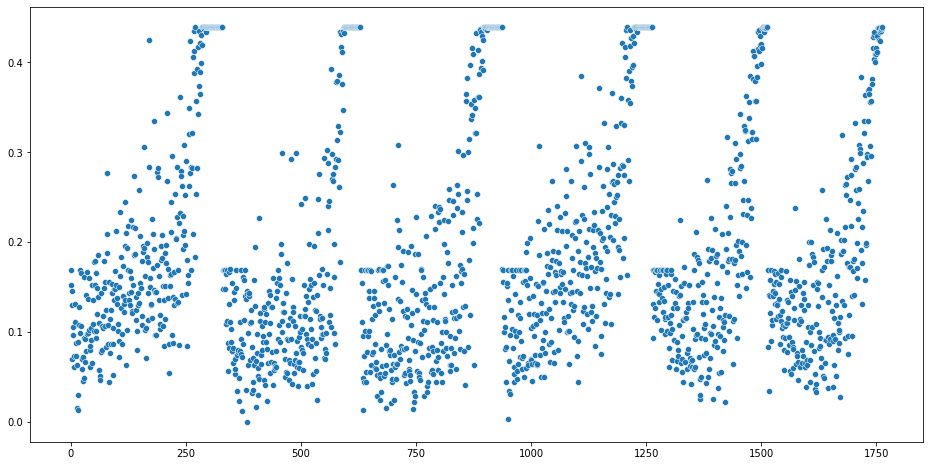

In [29]:
# Scaling

model_ocsvm.fit(train_data)
#positive : inlier , negative : outlier
ocsvm_anomaly_score = np.max(model_ocsvm.decision_function(test_data))-(model_ocsvm.decision_function(test_data))
sns.scatterplot(test_data.index,ocsvm_anomaly_score)

# practice

Minimum Covariance Determinant
Local Outlier Factor
Gaussian Mixture Model
One Class SVM
AutoEncoder


AttributeError: ignored

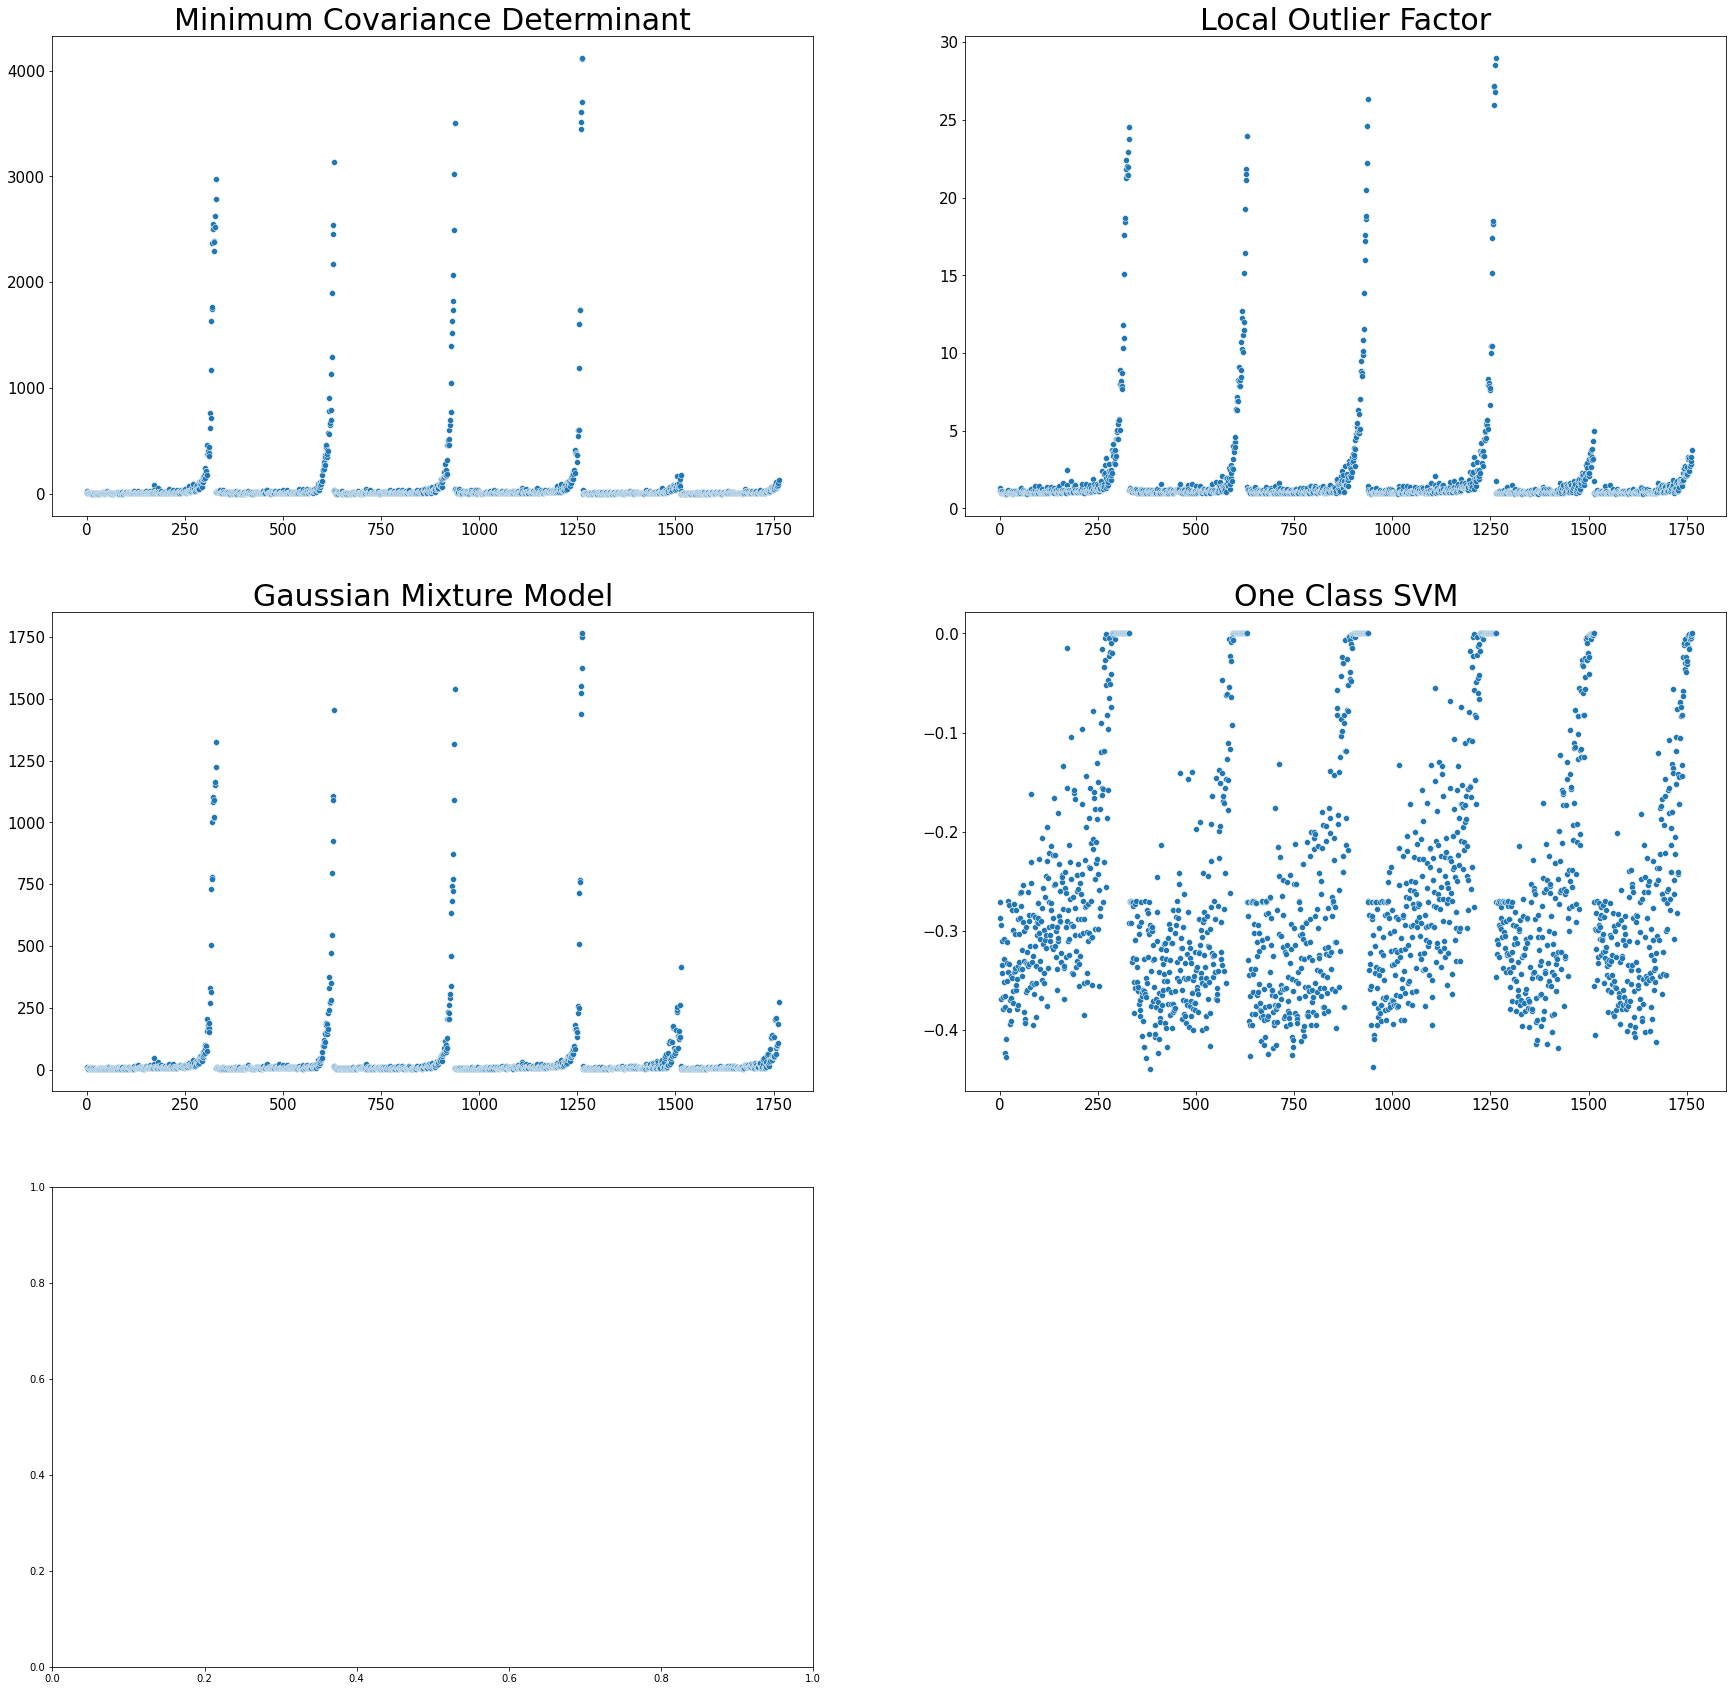

In [76]:
model_dict = {'Minimum Covariance Determinant':model_mcd,'Local Outlier Factor':model_lof,'Gaussian Mixture Model':best_gmm,'One Class SVM':model_ocsvm,'AutoEncoder':model_ae}
plt.rcParams['figure.figsize'] = (30, 30)
for i,model in enumerate(model_dict.keys()):
    plt.subplot(3, 2,i+1)
    print(model)

    if model == 'Minimum Covariance Determinant':
      sns.scatterplot(test_data.index, model_dict[model].decision_function(test_data))
    elif model == 'Local Outlier Factor' or 'Gaussian Mixture Model':
      sns.scatterplot(test_data.index, -(model_dict[model].score_samples(test_data)))
    elif model == 'One Class SVM':
      sns.scatterplot(test_data.index, np.max(model_dict[model].decision_function(test_data))-(model_dict[model].decision_function(test_data)))
    else:
      print('ae')
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
    plt.title(model,fontsize=30)

AttributeError: ignored

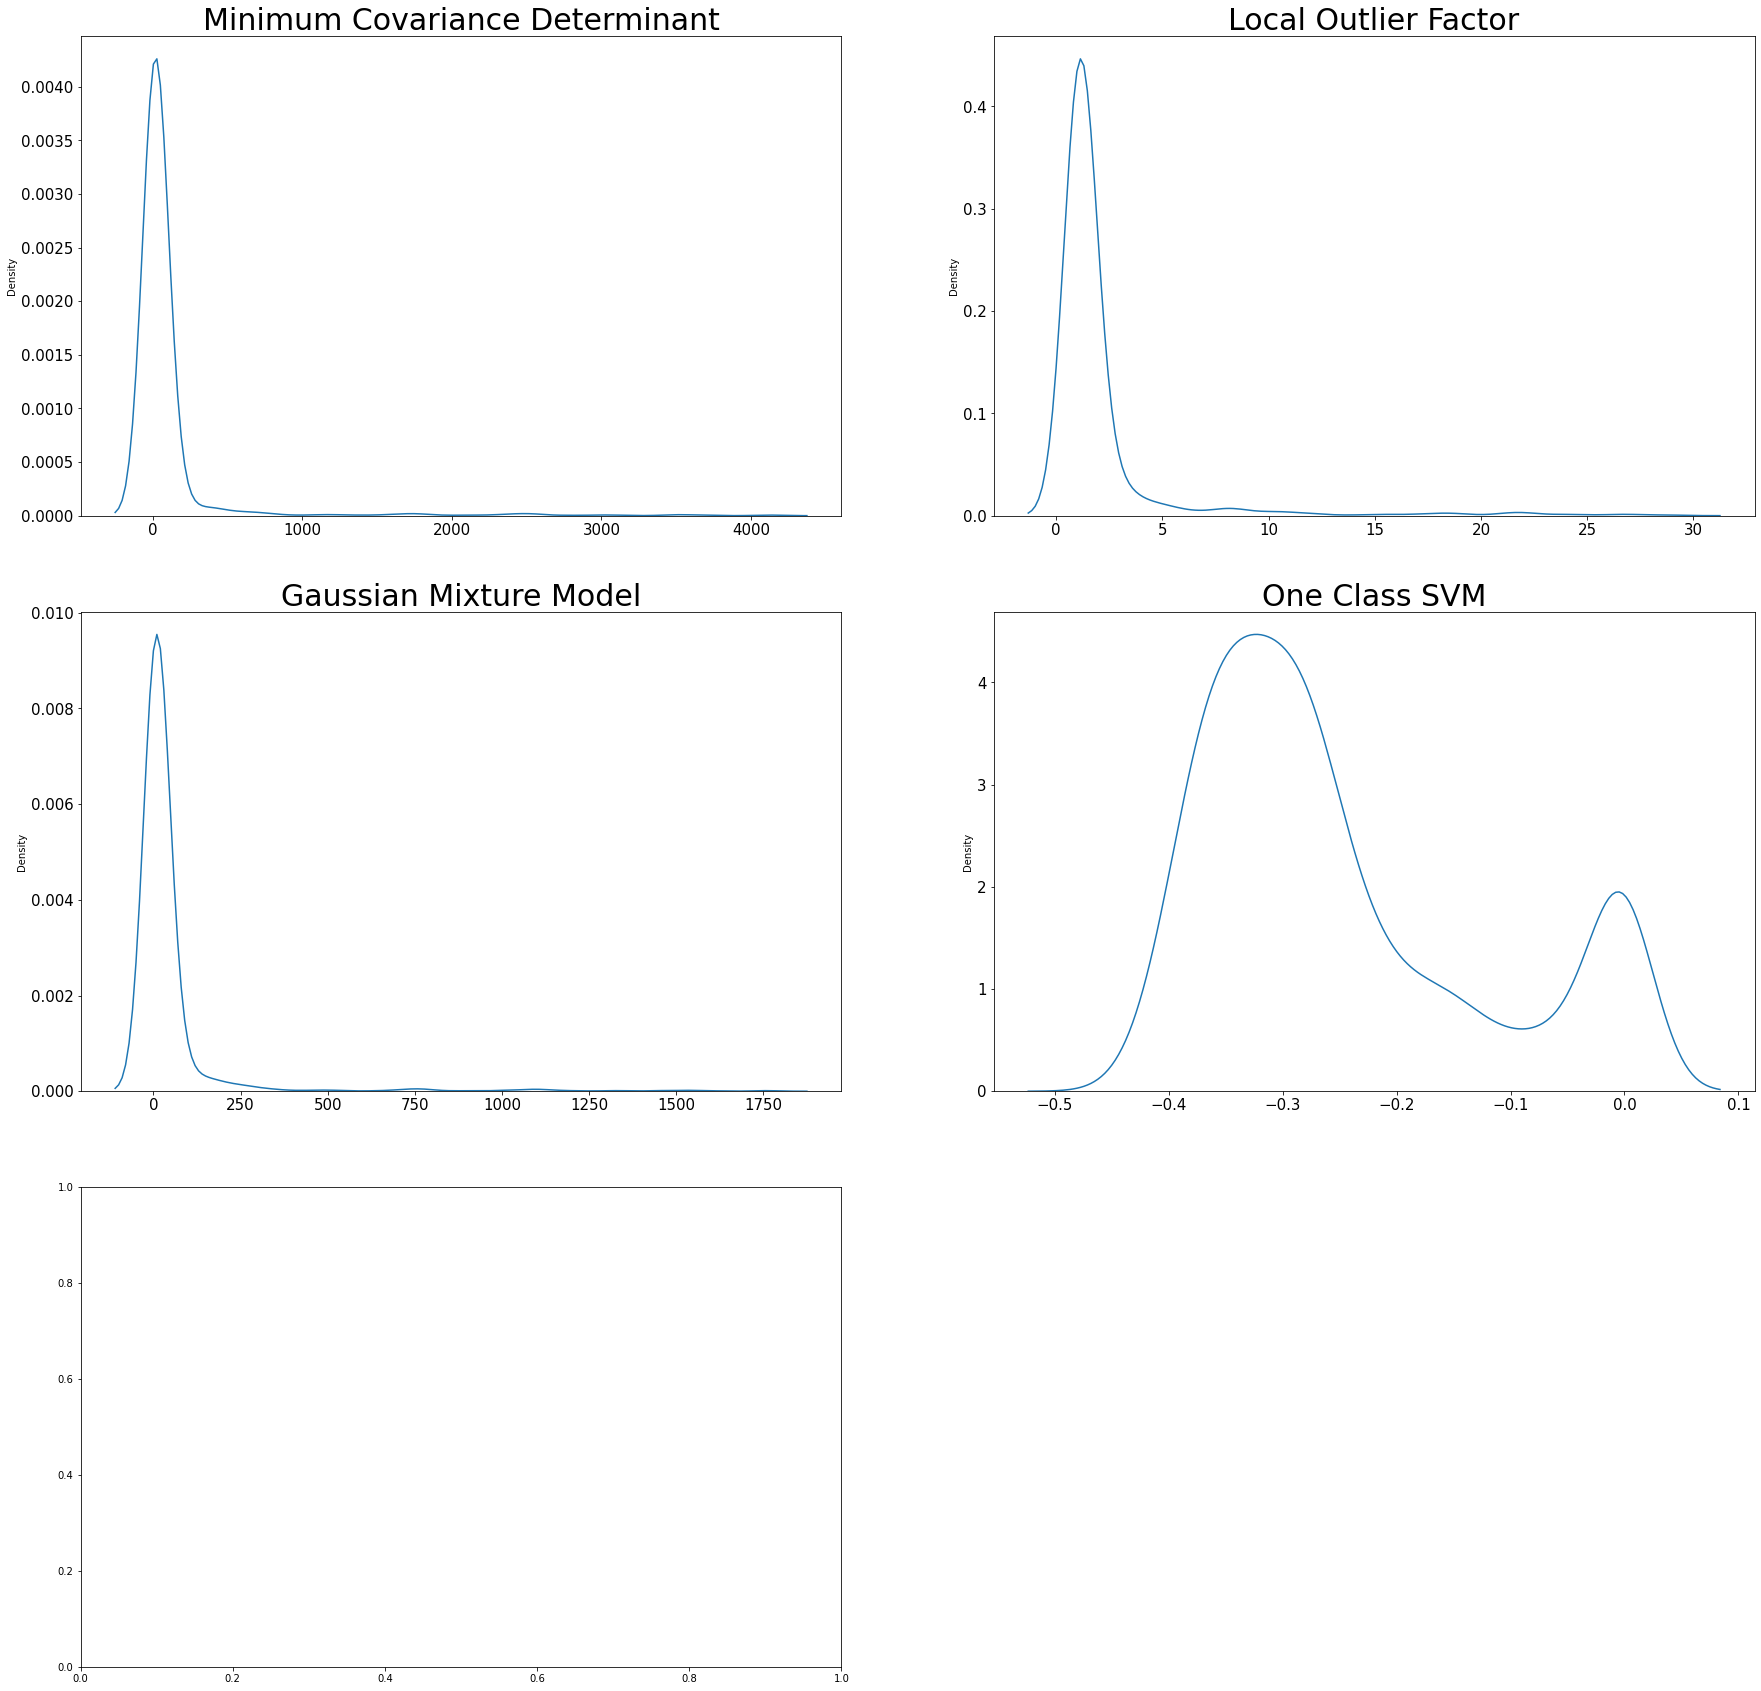

In [68]:
model_dict = {'Minimum Covariance Determinant':model_mcd,'Local Outlier Factor':model_lof,'Gaussian Mixture Model':best_gmm,'One Class SVM':model_ocsvm,'AutoEncoder':model_ae}
plt.rcParams['figure.figsize'] = (30, 30)
for i,model in enumerate(model_dict.keys()):
    plt.subplot(3, 2,i+1)
    #if model in []:decision_function, score_samples, z-score 나누기
    if model == 'Minimum Covariance Determinant':
      sns.kdeplot(model_dict[model].decision_function(test_data))
    elif model == 'Local Outlier Factor' or 'Gaussian Mixture Model':
      sns.kdeplot(-(model_dict[model].score_samples(test_data)))
    elif model == 'One Class SVM':
      ocsvm_anomaly_score = np.max(model_dict[model].decision_function(test_data))-(model_dict[model].decision_function(test_data))
      sns.kdeplot(ocsvm_anomaly_score)
    elif model == 'AutoEncoder':
      pass
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
    plt.title(model,fontsize=30)